# Import data

In [66]:
# Main packages 

import pandas as pd
import numpy as np
import torch 
import torch.nn as nn
import matplotlib.pyplot as plt

# Import data
data = pd.read_json('data/Sarcasm-Detection/Sarcasm_Headlines_Dataset_v2.json', lines=True)
data.drop(columns='article_link', inplace=True)
data.head()

,is_sarcastic,headline
0,1,thirtysomething scientists unveil doomsday clo...
1,0,dem rep. totally nails why congress is falling...
2,0,eat your veggies: 9 deliciously different recipes
3,1,inclement weather prevents liar from getting t...
4,1,mother comes pretty close to using word 'strea...


# Is it balanced?

In [67]:
data['is_sarcastic'].sum()/len(data)

0.476396799329117

Yes, not exactly but around half of the sentences are sarcasm

# Text preprocessing

In [68]:
from sklearn.model_selection import train_test_split
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

tokenizer = get_tokenizer('basic_english')
def tokenize(text):
    return tokenizer(text)

data['tokens'] = data['headline'].apply(tokenize)
data.head()

,is_sarcastic,headline,tokens
0,1,thirtysomething scientists unveil doomsday clo...,"[thirtysomething, scientists, unveil, doomsday..."
1,0,dem rep. totally nails why congress is falling...,"[dem, rep, ., totally, nails, why, congress, i..."
2,0,eat your veggies: 9 deliciously different recipes,"[eat, your, veggies, 9, deliciously, different..."
3,1,inclement weather prevents liar from getting t...,"[inclement, weather, prevents, liar, from, get..."
4,1,mother comes pretty close to using word 'strea...,"[mother, comes, pretty, close, to, using, word..."


# Build Vocabulary

In [69]:
def yield_tokens(data_iter):
    for sentence in data_iter:
        yield tokenize(sentence)

vocab = build_vocab_from_iterator(yield_tokens(data['headline']), specials = ['<unk>', '<pad>'])
vocab.set_default_index(vocab['<unk>'])
vocab

Vocab()

# Convert tokens to indices

In [70]:
data['numerical'] = data['tokens'].apply(lambda x: vocab(x))
data.head()

,is_sarcastic,headline,tokens,numerical
0,1,thirtysomething scientists unveil doomsday clo...,"[thirtysomething, scientists, unveil, doomsday...","[27581, 356, 3312, 6539, 2127, 4, 685, 1173]"
1,0,dem rep. totally nails why congress is falling...,"[dem, rep, ., totally, nails, why, congress, i...","[7676, 1659, 12, 745, 3238, 55, 241, 16, 1926,..."
2,0,eat your veggies: 9 deliciously different recipes,"[eat, your, veggies, 9, deliciously, different...","[917, 43, 15110, 604, 18819, 614, 1499]"
3,1,inclement weather prevents liar from getting t...,"[inclement, weather, prevents, liar, from, get...","[13039, 1677, 6968, 4733, 19, 149, 3, 158]"
4,1,mother comes pretty close to using word 'strea...,"[mother, comes, pretty, close, to, using, word...","[284, 489, 301, 1016, 3, 578, 634, 2, 4438, 2,..."


# Add padding

In [71]:
from torch.nn.utils.rnn import pad_sequence
def pad_sequences(sequences, padding_value = 0):
    return pad_sequence([torch.tensor(seq) for seq in sequences], batch_first=True, padding_value=padding_value)
padded_sequences = pad_sequences(data['numerical'].tolist())
padded_sequences, padded_sequences.shape

(tensor([[27581,   356,  3312,  ...,     0,     0,     0],
         [ 7676,  1659,    12,  ...,     0,     0,     0],
         [  917,    43, 15110,  ...,     0,     0,     0],
         ...,
         [    6,   103,   598,  ...,     0,     0,     0],
         [ 1866,  1210,  3166,  ...,     0,     0,     0],
         [  191,  3152,    27,  ...,     0,     0,     0]]),
 torch.Size([28619, 166]))

# Split data

In [72]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, data['is_sarcastic'].values, test_size = 0.3)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size = 0.33)

X_train.shape[0], X_test.shape[0], X_val.shape[0]

(20033, 5752, 2834)

# Create Dataset

In [73]:
from torch.utils.data import Dataset
class SarcasmDataset(Dataset):
    def __init__(self, input, labels):
        self.input = input
        self.labels = labels
    
    def __len__(self):
        return len(self.input)

    def __getitem__(self, idx):
        input = self.input[idx]
        label = self.labels[idx]
        
        non_pad = (input != 0).sum()
        
        
        return torch.tensor(input, dtype=torch.long), torch.tensor(label, dtype=torch.float), torch.tensor(non_pad, dtype = torch.float)

# Create Dataloader

In [74]:
from torch.utils.data import DataLoader, TensorDataset
BATCH_SIZE = 64

# Instantiate the dataset
train_dataset = SarcasmDataset(X_train, y_train)
val_dataset = SarcasmDataset(X_val, y_val)
test_dataset = SarcasmDataset(X_test, y_test)

# Create DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False, drop_last=True)

# Create RNN model 0

In [75]:
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
class SarcsmDetectorV1(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim, num_layers = 1):
        super(SarcsmDetectorV1, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.rnn = nn.RNN(embed_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, lengths):
        x = self.embedding(x)

         # Pack the sequences
        packed_input = pack_padded_sequence(x, lengths, batch_first=True, enforce_sorted=False)
        packed_output, h_n = self.rnn(packed_input)
        
        # Unpack the sequences
        output, _ = pad_packed_sequence(packed_output, batch_first=True)
        h_n = h_n[-1]
        out = self.fc(h_n)
        out = self.sigmoid(out)
        return out

# Hyper parameters  
vocab_size = len(vocab)
embed_dim = 100
hidden_dim = 200
output_dim = 1

# agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
rnn0 = SarcsmDetectorV1(vocab_size, embed_dim, hidden_dim, output_dim, num_layers=1).to(device)

# Loss and optimizer

In [76]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(rnn0.parameters(), lr = 0.0001)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience = 4)

# Train model

In [77]:
from tqdm import tqdm
num_epochs = 100

best_val_loss = float('inf')
counter = 0
max_count = 10
for epoch in range(num_epochs):
    rnn0.train()
    avg_train_loss = 0
    train_acc = 0
    for inputs, labels, lengths in tqdm(train_dataloader):
        inputs, labels = inputs.to(device) , labels.to(device)
        
        # Prediction
        outputs = rnn0(inputs, lengths).squeeze()
        
        # Calculate and acumulate loss
        loss = loss_fn(outputs, labels.float())
        avg_train_loss += loss.item()

        # Calculate accuracy
        train_acc += (outputs.round() == labels).sum().item()/len(labels)

        # Optimizer
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_acc /= len(train_dataloader)
    avg_train_loss /= len(train_dataloader)

    # Validate
    avg_val_loss = 0
    val_acc = 0
    rnn0.eval()
    with torch.no_grad():
        for inputs, labels, lengths in val_dataloader:
            inputs, labels = inputs.to(device) , labels.to(device)
            
            # Prediction
            outputs = rnn0(inputs, lengths).squeeze()
            
            # Calculate and acumulate loss
            loss = loss_fn(outputs, labels.float())
            avg_val_loss += loss.item()

            # Calculate acc
            val_acc += (outputs.round() == labels).sum().item()/len(inputs)

        val_acc /= len(val_dataloader)
        avg_val_loss /= len(val_dataloader)
    
    print(f'Epoch: {epoch} | Train Loss: {avg_train_loss:.4f} | Train Acc: {100*train_acc:.2f}% | Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc*100:.2f}%')

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(rnn0.state_dict(), 'Saved Models/Sarcasm Det Models/best_rnn0.pth')
        print(f'Saving model with loss: {avg_val_loss}')
        counter = 0
    else:
        counter += 1

    if counter == max_count:
        break
    scheduler.step(avg_val_loss)

  0%|          | 0/313 [00:00<?, ?it/s]

C:\Users\gilbe\AppData\Local\Temp\ipykernel_19196\1524819709.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(input, dtype=torch.long), torch.tensor(label, dtype=torch.float), torch.tensor(non_pad, dtype = torch.float)
100%|██████████| 313/313 [00:04<00:00, 74.48it/s]


Epoch: 0 | Train Loss: 0.6556 | Train Acc: 58.95% | Val Loss: 0.5833 | Val Acc: 68.00%
Saving model with loss: 0.5833211161873557


100%|██████████| 313/313 [00:04<00:00, 77.18it/s]


Epoch: 1 | Train Loss: 0.5640 | Train Acc: 70.73% | Val Loss: 0.5510 | Val Acc: 71.56%
Saving model with loss: 0.5509734478863803


100%|██████████| 313/313 [00:04<00:00, 74.90it/s]


Epoch: 2 | Train Loss: 0.5365 | Train Acc: 73.00% | Val Loss: 0.5343 | Val Acc: 72.19%
Saving model with loss: 0.5342639081857421


100%|██████████| 313/313 [00:04<00:00, 76.14it/s]


Epoch: 3 | Train Loss: 0.5114 | Train Acc: 74.85% | Val Loss: 0.5234 | Val Acc: 73.69%
Saving model with loss: 0.5234032246199521


100%|██████████| 313/313 [00:04<00:00, 75.01it/s]


Epoch: 4 | Train Loss: 0.4879 | Train Acc: 76.47% | Val Loss: 0.5005 | Val Acc: 74.86%
Saving model with loss: 0.5004627880724993


100%|██████████| 313/313 [00:04<00:00, 77.21it/s]


Epoch: 5 | Train Loss: 0.4651 | Train Acc: 78.06% | Val Loss: 0.4910 | Val Acc: 75.67%
Saving model with loss: 0.4910289699381048


100%|██████████| 313/313 [00:03<00:00, 78.49it/s]


Epoch: 6 | Train Loss: 0.4433 | Train Acc: 79.35% | Val Loss: 0.4832 | Val Acc: 76.24%
Saving model with loss: 0.48322479968721216


100%|██████████| 313/313 [00:04<00:00, 75.21it/s]


Epoch: 7 | Train Loss: 0.4238 | Train Acc: 80.70% | Val Loss: 0.4786 | Val Acc: 75.96%
Saving model with loss: 0.4786287166855552


100%|██████████| 313/313 [00:04<00:00, 74.57it/s]


Epoch: 8 | Train Loss: 0.4042 | Train Acc: 81.76% | Val Loss: 0.4658 | Val Acc: 77.02%
Saving model with loss: 0.4658035365017978


100%|██████████| 313/313 [00:04<00:00, 74.47it/s]


Epoch: 9 | Train Loss: 0.3850 | Train Acc: 82.78% | Val Loss: 0.4553 | Val Acc: 77.88%
Saving model with loss: 0.4553419351577759


100%|██████████| 313/313 [00:04<00:00, 74.84it/s]


Epoch: 10 | Train Loss: 0.3643 | Train Acc: 84.00% | Val Loss: 0.4486 | Val Acc: 78.12%
Saving model with loss: 0.4485705582932992


100%|██████████| 313/313 [00:04<00:00, 75.42it/s]


Epoch: 11 | Train Loss: 0.3459 | Train Acc: 84.90% | Val Loss: 0.4434 | Val Acc: 78.16%
Saving model with loss: 0.4434040805155581


100%|██████████| 313/313 [00:03<00:00, 78.44it/s]


Epoch: 12 | Train Loss: 0.3298 | Train Acc: 86.00% | Val Loss: 0.4386 | Val Acc: 79.58%
Saving model with loss: 0.43858146836811845


100%|██████████| 313/313 [00:03<00:00, 80.04it/s]


Epoch: 13 | Train Loss: 0.3100 | Train Acc: 86.91% | Val Loss: 0.4431 | Val Acc: 79.44%


100%|██████████| 313/313 [00:04<00:00, 76.25it/s]


Epoch: 14 | Train Loss: 0.2927 | Train Acc: 87.85% | Val Loss: 0.4353 | Val Acc: 79.72%
Saving model with loss: 0.4353467056697065


100%|██████████| 313/313 [00:04<00:00, 74.50it/s]


Epoch: 15 | Train Loss: 0.2782 | Train Acc: 88.30% | Val Loss: 0.4392 | Val Acc: 79.62%


100%|██████████| 313/313 [00:04<00:00, 75.43it/s]


Epoch: 16 | Train Loss: 0.2621 | Train Acc: 89.08% | Val Loss: 0.4498 | Val Acc: 80.01%


100%|██████████| 313/313 [00:04<00:00, 78.00it/s]


Epoch: 17 | Train Loss: 0.2473 | Train Acc: 90.02% | Val Loss: 0.4489 | Val Acc: 80.43%


100%|██████████| 313/313 [00:04<00:00, 77.48it/s]


Epoch: 18 | Train Loss: 0.2307 | Train Acc: 90.90% | Val Loss: 0.4690 | Val Acc: 81.00%


100%|██████████| 313/313 [00:04<00:00, 77.57it/s]


Epoch: 19 | Train Loss: 0.2151 | Train Acc: 91.43% | Val Loss: 0.4620 | Val Acc: 80.86%


100%|██████████| 313/313 [00:04<00:00, 77.03it/s]


Epoch: 20 | Train Loss: 0.1812 | Train Acc: 93.28% | Val Loss: 0.4523 | Val Acc: 81.46%


100%|██████████| 313/313 [00:03<00:00, 78.37it/s]


Epoch: 21 | Train Loss: 0.1729 | Train Acc: 93.63% | Val Loss: 0.4540 | Val Acc: 81.57%


100%|██████████| 313/313 [00:04<00:00, 77.18it/s]


Epoch: 22 | Train Loss: 0.1695 | Train Acc: 93.76% | Val Loss: 0.4605 | Val Acc: 81.39%


100%|██████████| 313/313 [00:04<00:00, 78.23it/s]


Epoch: 23 | Train Loss: 0.1668 | Train Acc: 93.86% | Val Loss: 0.4738 | Val Acc: 81.18%


100%|██████████| 313/313 [00:03<00:00, 78.89it/s]


Epoch: 24 | Train Loss: 0.1644 | Train Acc: 93.93% | Val Loss: 0.4670 | Val Acc: 81.39%


# Load best model

In [78]:
rnn0.load_state_dict(torch.load('Saved Models/Sarcasm Det Models/best_rnn0.pth'))

<All keys matched successfully>

# Test model

In [79]:
rnn0.eval()
rnn0_test_loss = 0
rnn0_test_acc = 0
with torch.no_grad():
    for inputs, labels, lengths in test_dataloader:
        inputs, labels = inputs.to(device) , labels.to(device)
        
        # Prediction
        outputs = rnn0(inputs, lengths).squeeze()
        
        # Calculate and acumulate loss
        loss = loss_fn(outputs, labels.float())
        rnn0_test_loss += loss.item()

        # Calculate acc
        rnn0_test_acc += (outputs.round() == labels).sum().item()/len(inputs)

    rnn0_test_acc /= len(test_dataloader)
    rnn0_test_loss /= len(test_dataloader)
print(f'RNN0:')
print(f'     Test Loss: {rnn0_test_loss} | Test Acc:{rnn0_test_acc}')

C:\Users\gilbe\AppData\Local\Temp\ipykernel_19196\1524819709.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(input, dtype=torch.long), torch.tensor(label, dtype=torch.float), torch.tensor(non_pad, dtype = torch.float)


RNN0:
     Test Loss: 0.44397397389572657 | Test Acc:0.7970505617977528


We can see that the model is slightly overfitting, lets try to add drops for regularization

# Add dropout regularization

In [80]:
class SarcsmDetectorV2(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim, num_layers = 1, p_drop = 0.2):
        super(SarcsmDetectorV2, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.rnn = nn.RNN(embed_dim, hidden_dim, num_layers, batch_first=True)
        self.dropout = nn.Dropout(p_drop)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, lengths):
        x = self.embedding(x)
        x = self.dropout(x)
         # Pack the sequences
        packed_input = pack_padded_sequence(x, lengths, batch_first=True, enforce_sorted=False)
        _, h_n = self.rnn(packed_input)
        
        h_n = h_n[-1]
        h_n = self.dropout(h_n)
        out = self.fc(h_n)
        out = self.sigmoid(out)
        return out

In [81]:
rnn1 = SarcsmDetectorV2(vocab_size, embed_dim, hidden_dim, output_dim, p_drop=0.4).to(device)
optimizer = torch.optim.Adam(rnn1.parameters(), lr = 0.0001)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience = 4)

best_val_loss = float('inf')
counter = 0
max_count = 10
for epoch in range(num_epochs):
    rnn1.train()
    avg_train_loss = 0
    train_acc = 0
    for inputs, labels, lengths in tqdm(train_dataloader):
        inputs, labels = inputs.to(device) , labels.to(device)
        
        # Prediction
        outputs = rnn1(inputs, lengths).squeeze()
        
        # Calculate and acumulate loss
        loss = loss_fn(outputs, labels.float())
        avg_train_loss += loss.item()

        # Calculate accuracy
        train_acc += (outputs.round() == labels).sum().item()/len(labels)

        # Optimizer
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_acc /= len(train_dataloader)
    avg_train_loss /= len(train_dataloader)

    # Validate
    avg_val_loss = 0
    val_acc = 0
    rnn1.eval()
    with torch.no_grad():
        for inputs, labels, lengths in val_dataloader:
            inputs, labels = inputs.to(device) , labels.to(device)
            
            # Prediction
            outputs = rnn1(inputs, lengths).squeeze()
            
            # Calculate and acumulate loss
            loss = loss_fn(outputs, labels.float())
            avg_val_loss += loss.item()

            # Calculate acc
            val_acc += (outputs.round() == labels).sum().item()/len(inputs)

        val_acc /= len(val_dataloader)
        avg_val_loss /= len(val_dataloader)
    
    print(f'Epoch: {epoch} | Train Loss: {avg_train_loss:.4f} | Train Acc: {100*train_acc:.2f}% | Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc*100:.2f}%')

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(rnn1.state_dict(), 'Saved Models/Sarcasm Det Models/best_rnn1.pth')
        print(f'Saving model with loss: {avg_val_loss}')
        counter = 0
    else:
        counter += 1

    if counter == max_count:
        break
    scheduler.step(avg_val_loss)

  0%|          | 0/313 [00:00<?, ?it/s]C:\Users\gilbe\AppData\Local\Temp\ipykernel_19196\1524819709.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(input, dtype=torch.long), torch.tensor(label, dtype=torch.float), torch.tensor(non_pad, dtype = torch.float)
100%|██████████| 313/313 [00:03<00:00, 82.37it/s]


Epoch: 0 | Train Loss: 0.6912 | Train Acc: 53.95% | Val Loss: 0.6490 | Val Acc: 61.65%
Saving model with loss: 0.6490102992816404


100%|██████████| 313/313 [00:03<00:00, 78.93it/s]


Epoch: 1 | Train Loss: 0.6228 | Train Acc: 65.38% | Val Loss: 0.5766 | Val Acc: 70.24%
Saving model with loss: 0.5766388577493754


100%|██████████| 313/313 [00:04<00:00, 78.10it/s]


Epoch: 2 | Train Loss: 0.5973 | Train Acc: 68.20% | Val Loss: 0.5652 | Val Acc: 71.34%
Saving model with loss: 0.5651861700144681


100%|██████████| 313/313 [00:04<00:00, 77.36it/s]


Epoch: 3 | Train Loss: 0.5823 | Train Acc: 69.37% | Val Loss: 0.5594 | Val Acc: 71.95%
Saving model with loss: 0.5594189180569216


100%|██████████| 313/313 [00:03<00:00, 79.86it/s]


Epoch: 4 | Train Loss: 0.5697 | Train Acc: 70.42% | Val Loss: 0.5668 | Val Acc: 72.05%


100%|██████████| 313/313 [00:03<00:00, 81.87it/s]


Epoch: 5 | Train Loss: 0.5581 | Train Acc: 71.31% | Val Loss: 0.5449 | Val Acc: 72.69%
Saving model with loss: 0.5448576740243218


100%|██████████| 313/313 [00:04<00:00, 77.24it/s]


Epoch: 6 | Train Loss: 0.5459 | Train Acc: 72.04% | Val Loss: 0.5320 | Val Acc: 74.11%
Saving model with loss: 0.531990608708425


100%|██████████| 313/313 [00:03<00:00, 78.71it/s]


Epoch: 7 | Train Loss: 0.5357 | Train Acc: 72.83% | Val Loss: 0.5280 | Val Acc: 74.43%
Saving model with loss: 0.5280227207324721


100%|██████████| 313/313 [00:03<00:00, 78.70it/s]


Epoch: 8 | Train Loss: 0.5235 | Train Acc: 73.78% | Val Loss: 0.5348 | Val Acc: 74.75%


100%|██████████| 313/313 [00:03<00:00, 79.35it/s]


Epoch: 9 | Train Loss: 0.5065 | Train Acc: 74.69% | Val Loss: 0.5080 | Val Acc: 75.82%
Saving model with loss: 0.5080201625823975


100%|██████████| 313/313 [00:03<00:00, 81.84it/s]


Epoch: 10 | Train Loss: 0.4998 | Train Acc: 75.50% | Val Loss: 0.5105 | Val Acc: 75.50%


100%|██████████| 313/313 [00:03<00:00, 79.50it/s]


Epoch: 11 | Train Loss: 0.4878 | Train Acc: 76.02% | Val Loss: 0.4883 | Val Acc: 76.60%
Saving model with loss: 0.48830711299722845


100%|██████████| 313/313 [00:04<00:00, 77.91it/s]


Epoch: 12 | Train Loss: 0.4840 | Train Acc: 76.59% | Val Loss: 0.4855 | Val Acc: 77.20%
Saving model with loss: 0.4855275519869544


100%|██████████| 313/313 [00:03<00:00, 78.76it/s]


Epoch: 13 | Train Loss: 0.4706 | Train Acc: 77.52% | Val Loss: 0.4758 | Val Acc: 77.13%
Saving model with loss: 0.475813435559923


100%|██████████| 313/313 [00:04<00:00, 77.62it/s]


Epoch: 14 | Train Loss: 0.4625 | Train Acc: 77.95% | Val Loss: 0.4774 | Val Acc: 78.41%


100%|██████████| 313/313 [00:03<00:00, 79.75it/s]


Epoch: 15 | Train Loss: 0.4516 | Train Acc: 78.84% | Val Loss: 0.4746 | Val Acc: 78.20%
Saving model with loss: 0.4745804965496063


100%|██████████| 313/313 [00:03<00:00, 81.00it/s]


Epoch: 16 | Train Loss: 0.4441 | Train Acc: 78.82% | Val Loss: 0.4549 | Val Acc: 78.84%
Saving model with loss: 0.45493000000715256


100%|██████████| 313/313 [00:03<00:00, 78.53it/s]


Epoch: 17 | Train Loss: 0.4386 | Train Acc: 79.18% | Val Loss: 0.4648 | Val Acc: 78.87%


100%|██████████| 313/313 [00:03<00:00, 79.16it/s]


Epoch: 18 | Train Loss: 0.4299 | Train Acc: 79.91% | Val Loss: 0.4405 | Val Acc: 79.94%
Saving model with loss: 0.4405497590249235


100%|██████████| 313/313 [00:03<00:00, 80.17it/s]


Epoch: 19 | Train Loss: 0.4171 | Train Acc: 80.45% | Val Loss: 0.4399 | Val Acc: 79.40%
Saving model with loss: 0.43988846106962726


100%|██████████| 313/313 [00:03<00:00, 78.39it/s]


Epoch: 20 | Train Loss: 0.4141 | Train Acc: 80.76% | Val Loss: 0.4328 | Val Acc: 79.87%
Saving model with loss: 0.43281158872626047


100%|██████████| 313/313 [00:04<00:00, 77.01it/s]


Epoch: 21 | Train Loss: 0.4091 | Train Acc: 81.50% | Val Loss: 0.4426 | Val Acc: 80.50%


100%|██████████| 313/313 [00:03<00:00, 80.78it/s]


Epoch: 22 | Train Loss: 0.4032 | Train Acc: 81.61% | Val Loss: 0.4332 | Val Acc: 80.86%


100%|██████████| 313/313 [00:03<00:00, 81.32it/s]


Epoch: 23 | Train Loss: 0.3997 | Train Acc: 81.65% | Val Loss: 0.4164 | Val Acc: 80.40%
Saving model with loss: 0.41642245379361237


100%|██████████| 313/313 [00:03<00:00, 80.35it/s]


Epoch: 24 | Train Loss: 0.3947 | Train Acc: 81.84% | Val Loss: 0.4120 | Val Acc: 81.21%
Saving model with loss: 0.41202966936609964


100%|██████████| 313/313 [00:03<00:00, 78.60it/s]


Epoch: 25 | Train Loss: 0.3800 | Train Acc: 82.55% | Val Loss: 0.4347 | Val Acc: 80.82%


100%|██████████| 313/313 [00:03<00:00, 79.15it/s]


Epoch: 26 | Train Loss: 0.3761 | Train Acc: 83.05% | Val Loss: 0.4170 | Val Acc: 81.36%


100%|██████████| 313/313 [00:04<00:00, 77.51it/s]


Epoch: 27 | Train Loss: 0.3688 | Train Acc: 83.54% | Val Loss: 0.4144 | Val Acc: 81.53%


100%|██████████| 313/313 [00:03<00:00, 80.81it/s]


Epoch: 28 | Train Loss: 0.3674 | Train Acc: 83.36% | Val Loss: 0.4138 | Val Acc: 81.14%


100%|██████████| 313/313 [00:03<00:00, 81.01it/s]


Epoch: 29 | Train Loss: 0.3610 | Train Acc: 83.77% | Val Loss: 0.4228 | Val Acc: 80.93%


100%|██████████| 313/313 [00:03<00:00, 80.16it/s]


Epoch: 30 | Train Loss: 0.3483 | Train Acc: 84.45% | Val Loss: 0.4112 | Val Acc: 81.46%
Saving model with loss: 0.41119555790315976


100%|██████████| 313/313 [00:03<00:00, 79.34it/s]


Epoch: 31 | Train Loss: 0.3461 | Train Acc: 84.58% | Val Loss: 0.4091 | Val Acc: 81.32%
Saving model with loss: 0.4090628962625157


100%|██████████| 313/313 [00:03<00:00, 78.33it/s]


Epoch: 32 | Train Loss: 0.3452 | Train Acc: 84.79% | Val Loss: 0.4134 | Val Acc: 81.68%


100%|██████████| 313/313 [00:03<00:00, 79.17it/s]


Epoch: 33 | Train Loss: 0.3415 | Train Acc: 84.57% | Val Loss: 0.4105 | Val Acc: 81.64%


100%|██████████| 313/313 [00:03<00:00, 82.19it/s]


Epoch: 34 | Train Loss: 0.3412 | Train Acc: 84.90% | Val Loss: 0.4081 | Val Acc: 81.96%
Saving model with loss: 0.40813352912664413


100%|██████████| 313/313 [00:03<00:00, 80.98it/s]


Epoch: 35 | Train Loss: 0.3417 | Train Acc: 84.86% | Val Loss: 0.4074 | Val Acc: 81.78%
Saving model with loss: 0.40743359652432526


100%|██████████| 313/313 [00:03<00:00, 79.71it/s]


Epoch: 36 | Train Loss: 0.3382 | Train Acc: 85.08% | Val Loss: 0.4131 | Val Acc: 82.10%


100%|██████████| 313/313 [00:03<00:00, 79.26it/s]


Epoch: 37 | Train Loss: 0.3400 | Train Acc: 85.02% | Val Loss: 0.4062 | Val Acc: 81.92%
Saving model with loss: 0.40623976357958536


100%|██████████| 313/313 [00:03<00:00, 81.77it/s]


Epoch: 38 | Train Loss: 0.3399 | Train Acc: 85.12% | Val Loss: 0.4102 | Val Acc: 82.17%


100%|██████████| 313/313 [00:04<00:00, 77.15it/s]


Epoch: 39 | Train Loss: 0.3380 | Train Acc: 85.03% | Val Loss: 0.4024 | Val Acc: 82.07%
Saving model with loss: 0.4023651304570111


100%|██████████| 313/313 [00:04<00:00, 77.34it/s]


Epoch: 40 | Train Loss: 0.3391 | Train Acc: 85.02% | Val Loss: 0.4044 | Val Acc: 81.92%


100%|██████████| 313/313 [00:03<00:00, 79.28it/s]


Epoch: 41 | Train Loss: 0.3356 | Train Acc: 85.17% | Val Loss: 0.4128 | Val Acc: 81.96%


100%|██████████| 313/313 [00:03<00:00, 81.58it/s]


Epoch: 42 | Train Loss: 0.3338 | Train Acc: 85.36% | Val Loss: 0.4142 | Val Acc: 82.17%


100%|██████████| 313/313 [00:03<00:00, 83.51it/s]


Epoch: 43 | Train Loss: 0.3377 | Train Acc: 85.16% | Val Loss: 0.4074 | Val Acc: 82.14%


100%|██████████| 313/313 [00:03<00:00, 82.44it/s]


Epoch: 44 | Train Loss: 0.3351 | Train Acc: 85.18% | Val Loss: 0.4105 | Val Acc: 82.17%


100%|██████████| 313/313 [00:03<00:00, 80.92it/s]


Epoch: 45 | Train Loss: 0.3329 | Train Acc: 85.48% | Val Loss: 0.4083 | Val Acc: 82.21%


100%|██████████| 313/313 [00:03<00:00, 81.56it/s]


Epoch: 46 | Train Loss: 0.3349 | Train Acc: 85.50% | Val Loss: 0.4081 | Val Acc: 82.24%


100%|██████████| 313/313 [00:03<00:00, 82.13it/s]


Epoch: 47 | Train Loss: 0.3311 | Train Acc: 85.49% | Val Loss: 0.4089 | Val Acc: 82.03%


100%|██████████| 313/313 [00:03<00:00, 79.62it/s]


Epoch: 48 | Train Loss: 0.3314 | Train Acc: 85.50% | Val Loss: 0.4078 | Val Acc: 82.17%


100%|██████████| 313/313 [00:03<00:00, 81.60it/s]


Epoch: 49 | Train Loss: 0.3324 | Train Acc: 85.53% | Val Loss: 0.4096 | Val Acc: 82.07%


# Load and test model

In [82]:
rnn1.load_state_dict(torch.load('Saved Models/Sarcasm Det Models/best_rnn1.pth'))

rnn1.eval()
rnn1_test_loss = 0
rnn1_test_acc = 0
with torch.no_grad():
    for inputs, labels, lengths in test_dataloader:
        inputs, labels = inputs.to(device) , labels.to(device)
        
        # Prediction
        outputs = rnn1(inputs, lengths).squeeze()
        
        # Calculate and acumulate loss
        loss = loss_fn(outputs, labels.float())
        rnn1_test_loss += loss.item()

        # Calculate acc
        rnn1_test_acc += (outputs.round() == labels).sum().item()/len(inputs)

    rnn1_test_acc /= len(test_dataloader)
    rnn1_test_loss /= len(test_dataloader)
print(f'rnn1:')
print(f'     Test Loss: {rnn1_test_loss} | Test Acc:{rnn1_test_acc}')

C:\Users\gilbe\AppData\Local\Temp\ipykernel_19196\1524819709.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(input, dtype=torch.long), torch.tensor(label, dtype=torch.float), torch.tensor(non_pad, dtype = torch.float)


rnn1:
     Test Loss: 0.3986469897326459 | Test Acc:0.8258426966292135


# Try LSTM 

In [83]:
class SarcsmDetectorV3(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim, num_layers = 1, p_drop = 0.2):
        super(SarcsmDetectorV3, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers, batch_first=True)
        self.dropout = nn.Dropout(p_drop)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, lengths):
        x = self.embedding(x)
        x = self.dropout(x)
         # Pack the sequences
        packed_input = pack_padded_sequence(x, lengths, batch_first=True, enforce_sorted=False)
        _, (h_n, _) = self.lstm(packed_input)

        h_n = h_n[-1]
        h_n = self.dropout(h_n)
        out = self.fc(h_n)
        out = self.sigmoid(out)
        return out

# Train LSTM model (No dropout)

In [84]:
rnn2 = SarcsmDetectorV3(vocab_size, embed_dim, hidden_dim, output_dim, p_drop=0.0).to(device)
optimizer = torch.optim.Adam(rnn2.parameters(), lr = 0.0001)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience = 4)

best_val_loss = float('inf')
counter = 0
max_count = 10
for epoch in range(num_epochs):
    rnn2.train()
    avg_train_loss = 0
    train_acc = 0
    for inputs, labels, lengths in tqdm(train_dataloader):
        inputs, labels = inputs.to(device) , labels.to(device)
        
        # Prediction
        outputs = rnn2(inputs, lengths).squeeze()
        
        # Calculate and acumulate loss
        loss = loss_fn(outputs, labels.float())
        avg_train_loss += loss.item()

        # Calculate accuracy
        train_acc += (outputs.round() == labels).sum().item()/len(labels)

        # Optimizer
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_acc /= len(train_dataloader)
    avg_train_loss /= len(train_dataloader)

    # Validate
    avg_val_loss = 0
    val_acc = 0
    rnn2.eval()
    with torch.no_grad():
        for inputs, labels, lengths in val_dataloader:
            inputs, labels = inputs.to(device) , labels.to(device)
            
            # Prediction
            outputs = rnn2(inputs, lengths).squeeze()
            
            # Calculate and acumulate loss
            loss = loss_fn(outputs, labels.float())
            avg_val_loss += loss.item()

            # Calculate acc
            val_acc += (outputs.round() == labels).sum().item()/len(inputs)

        val_acc /= len(val_dataloader)
    
    print(f'Epoch: {epoch} | Train Loss: {avg_train_loss:.4f} | Train Acc: {100*train_acc:.2f}% | Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc*100:.2f}%')

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(rnn2.state_dict(), 'Saved Models/Sarcasm Det Models/best_rnn2.pth')
        print(f'Saving model with loss: {avg_val_loss}')
        counter = 0
    else:
        counter += 1

    if counter == max_count:
        break

  0%|          | 0/313 [00:00<?, ?it/s]C:\Users\gilbe\AppData\Local\Temp\ipykernel_19196\1524819709.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(input, dtype=torch.long), torch.tensor(label, dtype=torch.float), torch.tensor(non_pad, dtype = torch.float)
100%|██████████| 313/313 [00:04<00:00, 77.58it/s]


Epoch: 0 | Train Loss: 0.6457 | Train Acc: 62.18% | Val Loss: 24.8670 | Val Acc: 71.41%
Saving model with loss: 24.866981148719788


100%|██████████| 313/313 [00:04<00:00, 76.85it/s]


Epoch: 1 | Train Loss: 0.5267 | Train Acc: 73.48% | Val Loss: 22.5499 | Val Acc: 75.14%
Saving model with loss: 22.54989179968834


100%|██████████| 313/313 [00:04<00:00, 74.68it/s]


Epoch: 2 | Train Loss: 0.4723 | Train Acc: 77.11% | Val Loss: 20.9356 | Val Acc: 77.45%
Saving model with loss: 20.935552954673767


100%|██████████| 313/313 [00:04<00:00, 76.43it/s]


Epoch: 3 | Train Loss: 0.4222 | Train Acc: 80.42% | Val Loss: 19.6105 | Val Acc: 78.55%
Saving model with loss: 19.61047601699829


100%|██████████| 313/313 [00:04<00:00, 75.65it/s]


Epoch: 4 | Train Loss: 0.3792 | Train Acc: 83.14% | Val Loss: 18.6726 | Val Acc: 79.94%
Saving model with loss: 18.67260731756687


100%|██████████| 313/313 [00:03<00:00, 78.60it/s]


Epoch: 5 | Train Loss: 0.3425 | Train Acc: 84.97% | Val Loss: 18.0080 | Val Acc: 81.29%
Saving model with loss: 18.008045434951782


100%|██████████| 313/313 [00:03<00:00, 78.99it/s]


Epoch: 6 | Train Loss: 0.3121 | Train Acc: 86.56% | Val Loss: 17.8722 | Val Acc: 82.17%
Saving model with loss: 17.872244864702225


100%|██████████| 313/313 [00:04<00:00, 75.36it/s]


Epoch: 7 | Train Loss: 0.2830 | Train Acc: 88.30% | Val Loss: 18.1141 | Val Acc: 81.04%


100%|██████████| 313/313 [00:04<00:00, 75.24it/s]


Epoch: 8 | Train Loss: 0.2575 | Train Acc: 89.58% | Val Loss: 18.3368 | Val Acc: 82.17%


100%|██████████| 313/313 [00:04<00:00, 77.18it/s]


Epoch: 9 | Train Loss: 0.2337 | Train Acc: 90.62% | Val Loss: 18.6682 | Val Acc: 82.78%


100%|██████████| 313/313 [00:03<00:00, 78.60it/s]


Epoch: 10 | Train Loss: 0.2135 | Train Acc: 91.57% | Val Loss: 19.4007 | Val Acc: 82.00%


100%|██████████| 313/313 [00:03<00:00, 78.33it/s]


Epoch: 11 | Train Loss: 0.1933 | Train Acc: 92.55% | Val Loss: 20.0505 | Val Acc: 82.00%


100%|██████████| 313/313 [00:04<00:00, 78.17it/s]


Epoch: 12 | Train Loss: 0.1751 | Train Acc: 93.33% | Val Loss: 21.1386 | Val Acc: 82.17%


100%|██████████| 313/313 [00:04<00:00, 77.15it/s]


Epoch: 13 | Train Loss: 0.1566 | Train Acc: 94.05% | Val Loss: 21.5987 | Val Acc: 82.42%


100%|██████████| 313/313 [00:04<00:00, 78.12it/s]


Epoch: 14 | Train Loss: 0.1416 | Train Acc: 94.82% | Val Loss: 23.7694 | Val Acc: 82.56%


100%|██████████| 313/313 [00:04<00:00, 78.22it/s]


Epoch: 15 | Train Loss: 0.1288 | Train Acc: 95.45% | Val Loss: 23.8997 | Val Acc: 82.17%


100%|██████████| 313/313 [00:03<00:00, 78.31it/s]


Epoch: 16 | Train Loss: 0.1140 | Train Acc: 95.96% | Val Loss: 25.4554 | Val Acc: 82.14%


# Test Model 3

In [85]:
rnn2.load_state_dict(torch.load('Saved Models/Sarcasm Det Models/best_rnn2.pth'))

rnn2.eval()
rnn2_test_loss = 0
rnn2_test_acc = 0
with torch.no_grad():
    for inputs, labels, lengths in test_dataloader:
        inputs, labels = inputs.to(device) , labels.to(device)
        
        # Prediction
        outputs = rnn2(inputs, lengths).squeeze()
        
        # Calculate and acumulate loss
        loss = loss_fn(outputs, labels.float())
        rnn2_test_loss += loss.item()

        # Calculate acc
        rnn2_test_acc += (outputs.round() == labels).sum().item()/len(inputs)

    rnn2_test_acc /= len(test_dataloader)
    rnn2_test_loss /= len(test_dataloader)
print(f'rnn2:')
print(f'     Test Loss: {rnn2_test_loss} | Test Acc:{rnn2_test_acc}')

C:\Users\gilbe\AppData\Local\Temp\ipykernel_19196\1524819709.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(input, dtype=torch.long), torch.tensor(label, dtype=torch.float), torch.tensor(non_pad, dtype = torch.float)


rnn2:
     Test Loss: 0.3904631879557385 | Test Acc:0.8277738764044944


# Add dropout to LSTM

In [86]:
rnn3 = SarcsmDetectorV3(vocab_size, embed_dim, hidden_dim, output_dim, p_drop=0.4).to(device)
optimizer = torch.optim.Adam(rnn3.parameters(), lr = 0.0001)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience = 4)

best_val_loss = float('inf')
counter = 0
max_count = 10
for epoch in range(num_epochs):
    rnn3.train()
    avg_train_loss = 0
    train_acc = 0
    for inputs, labels, lengths in tqdm(train_dataloader):
        inputs, labels = inputs.to(device) , labels.to(device)
        
        # Prediction
        outputs = rnn3(inputs, lengths).squeeze()
        
        # Calculate and acumulate loss
        loss = loss_fn(outputs, labels.float())
        avg_train_loss += loss.item()

        # Calculate accuracy
        train_acc += (outputs.round() == labels).sum().item()/len(labels)

        # Optimizer
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_acc /= len(train_dataloader)
    avg_train_loss /= len(train_dataloader)

    # Validate
    avg_val_loss = 0
    val_acc = 0
    rnn3.eval()
    with torch.no_grad():
        for inputs, labels, lengths in val_dataloader:
            inputs, labels = inputs.to(device) , labels.to(device)
            
            # Prediction
            outputs = rnn3(inputs, lengths).squeeze()
            
            # Calculate and acumulate loss
            loss = loss_fn(outputs, labels.float())
            avg_val_loss += loss.item()

            # Calculate acc
            val_acc += (outputs.round() == labels).sum().item()/len(inputs)

        val_acc /= len(val_dataloader)
        avg_val_loss /= len(val_dataloader)
    
    print(f'Epoch: {epoch} | Train Loss: {avg_train_loss:.4f} | Train Acc: {100*train_acc:.2f}% | Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc*100:.2f}%')

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(rnn3.state_dict(), 'Saved Models/Sarcasm Det Models/best_rnn3.pth')
        print(f'Saving model with loss: {avg_val_loss}')
        counter = 0
    else:
        counter += 1

    if counter == max_count:
        break

  0%|          | 0/313 [00:00<?, ?it/s]C:\Users\gilbe\AppData\Local\Temp\ipykernel_19196\1524819709.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(input, dtype=torch.long), torch.tensor(label, dtype=torch.float), torch.tensor(non_pad, dtype = torch.float)
100%|██████████| 313/313 [00:04<00:00, 76.75it/s]


Epoch: 0 | Train Loss: 0.6850 | Train Acc: 54.63% | Val Loss: 0.6481 | Val Acc: 62.39%
Saving model with loss: 0.648052147843621


100%|██████████| 313/313 [00:04<00:00, 75.15it/s]


Epoch: 1 | Train Loss: 0.6032 | Train Acc: 67.53% | Val Loss: 0.5411 | Val Acc: 71.91%
Saving model with loss: 0.5410558141090653


100%|██████████| 313/313 [00:04<00:00, 74.13it/s]


Epoch: 2 | Train Loss: 0.5528 | Train Acc: 71.48% | Val Loss: 0.5066 | Val Acc: 74.04%
Saving model with loss: 0.5065722756765105


100%|██████████| 313/313 [00:04<00:00, 73.89it/s]


Epoch: 3 | Train Loss: 0.5159 | Train Acc: 74.28% | Val Loss: 0.4777 | Val Acc: 75.60%
Saving model with loss: 0.4776552780108018


100%|██████████| 313/313 [00:04<00:00, 76.67it/s]


Epoch: 4 | Train Loss: 0.4843 | Train Acc: 76.50% | Val Loss: 0.4551 | Val Acc: 77.88%
Saving model with loss: 0.4550791931423274


100%|██████████| 313/313 [00:04<00:00, 76.45it/s]


Epoch: 5 | Train Loss: 0.4568 | Train Acc: 78.27% | Val Loss: 0.4388 | Val Acc: 79.44%
Saving model with loss: 0.4387854987924749


100%|██████████| 313/313 [00:04<00:00, 77.17it/s]


Epoch: 6 | Train Loss: 0.4396 | Train Acc: 79.21% | Val Loss: 0.4290 | Val Acc: 80.43%
Saving model with loss: 0.42895813286304474


100%|██████████| 313/313 [00:04<00:00, 74.42it/s]


Epoch: 7 | Train Loss: 0.4283 | Train Acc: 79.88% | Val Loss: 0.4134 | Val Acc: 80.97%
Saving model with loss: 0.41340812837535684


100%|██████████| 313/313 [00:04<00:00, 74.80it/s]


Epoch: 8 | Train Loss: 0.4118 | Train Acc: 81.00% | Val Loss: 0.4078 | Val Acc: 81.32%
Saving model with loss: 0.40781780129129236


100%|██████████| 313/313 [00:04<00:00, 74.52it/s]


Epoch: 9 | Train Loss: 0.4051 | Train Acc: 81.40% | Val Loss: 0.4108 | Val Acc: 81.25%


100%|██████████| 313/313 [00:04<00:00, 76.08it/s]


Epoch: 10 | Train Loss: 0.3950 | Train Acc: 82.10% | Val Loss: 0.3997 | Val Acc: 82.32%
Saving model with loss: 0.3996831439435482


100%|██████████| 313/313 [00:04<00:00, 77.47it/s]


Epoch: 11 | Train Loss: 0.3825 | Train Acc: 82.60% | Val Loss: 0.3933 | Val Acc: 82.17%
Saving model with loss: 0.3932744698090987


100%|██████████| 313/313 [00:05<00:00, 54.71it/s]


Epoch: 12 | Train Loss: 0.3769 | Train Acc: 82.93% | Val Loss: 0.3856 | Val Acc: 82.56%
Saving model with loss: 0.38562585887583817


100%|██████████| 313/313 [00:04<00:00, 75.23it/s]


Epoch: 13 | Train Loss: 0.3685 | Train Acc: 83.29% | Val Loss: 0.3801 | Val Acc: 82.95%
Saving model with loss: 0.38009070909836074


100%|██████████| 313/313 [00:04<00:00, 74.66it/s]


Epoch: 14 | Train Loss: 0.3612 | Train Acc: 84.00% | Val Loss: 0.3922 | Val Acc: 83.03%


100%|██████████| 313/313 [00:04<00:00, 74.20it/s]


Epoch: 15 | Train Loss: 0.3512 | Train Acc: 84.59% | Val Loss: 0.3985 | Val Acc: 83.63%


100%|██████████| 313/313 [00:04<00:00, 74.07it/s]


Epoch: 16 | Train Loss: 0.3473 | Train Acc: 84.49% | Val Loss: 0.3743 | Val Acc: 83.56%
Saving model with loss: 0.37431942705403676


100%|██████████| 313/313 [00:04<00:00, 74.81it/s]


Epoch: 17 | Train Loss: 0.3424 | Train Acc: 84.64% | Val Loss: 0.3699 | Val Acc: 83.74%
Saving model with loss: 0.3699305101551793


100%|██████████| 313/313 [00:04<00:00, 74.28it/s]


Epoch: 18 | Train Loss: 0.3329 | Train Acc: 85.24% | Val Loss: 0.3687 | Val Acc: 84.73%
Saving model with loss: 0.36874090507626534


100%|██████████| 313/313 [00:04<00:00, 74.35it/s]


Epoch: 19 | Train Loss: 0.3269 | Train Acc: 85.74% | Val Loss: 0.3669 | Val Acc: 84.23%
Saving model with loss: 0.36688587679104373


100%|██████████| 313/313 [00:04<00:00, 73.56it/s]


Epoch: 20 | Train Loss: 0.3254 | Train Acc: 85.76% | Val Loss: 0.3885 | Val Acc: 84.30%


100%|██████████| 313/313 [00:04<00:00, 72.45it/s]


Epoch: 21 | Train Loss: 0.3186 | Train Acc: 86.01% | Val Loss: 0.3724 | Val Acc: 84.62%


100%|██████████| 313/313 [00:04<00:00, 74.96it/s]


Epoch: 22 | Train Loss: 0.3096 | Train Acc: 86.56% | Val Loss: 0.3859 | Val Acc: 84.02%


100%|██████████| 313/313 [00:04<00:00, 74.71it/s]


Epoch: 23 | Train Loss: 0.3078 | Train Acc: 86.95% | Val Loss: 0.3701 | Val Acc: 84.59%


100%|██████████| 313/313 [00:04<00:00, 74.84it/s]


Epoch: 24 | Train Loss: 0.3035 | Train Acc: 87.13% | Val Loss: 0.3684 | Val Acc: 84.73%


100%|██████████| 313/313 [00:04<00:00, 74.43it/s]


Epoch: 25 | Train Loss: 0.2956 | Train Acc: 87.28% | Val Loss: 0.3725 | Val Acc: 84.02%


100%|██████████| 313/313 [00:04<00:00, 74.85it/s]


Epoch: 26 | Train Loss: 0.2929 | Train Acc: 87.22% | Val Loss: 0.3713 | Val Acc: 84.69%


100%|██████████| 313/313 [00:04<00:00, 77.31it/s]


Epoch: 27 | Train Loss: 0.2889 | Train Acc: 87.61% | Val Loss: 0.3797 | Val Acc: 84.48%


100%|██████████| 313/313 [00:04<00:00, 75.47it/s]


Epoch: 28 | Train Loss: 0.2866 | Train Acc: 87.75% | Val Loss: 0.3731 | Val Acc: 84.48%


100%|██████████| 313/313 [00:04<00:00, 76.41it/s]


Epoch: 29 | Train Loss: 0.2781 | Train Acc: 87.91% | Val Loss: 0.3797 | Val Acc: 84.48%


# Test model 3

In [87]:
rnn3.load_state_dict(torch.load('Saved Models/Sarcasm Det Models/best_rnn3.pth'))

rnn3.eval()
rnn3_test_loss = 0
rnn3_test_acc = 0
with torch.no_grad():
    for inputs, labels, lengths in test_dataloader:
        inputs, labels = inputs.to(device) , labels.to(device)
        
        # Prediction
        outputs = rnn3(inputs, lengths).squeeze()
        
        # Calculate and acumulate loss
        loss = loss_fn(outputs, labels.float())
        rnn3_test_loss += loss.item()

        # Calculate acc
        rnn3_test_acc += (outputs.round() == labels).sum().item()/len(inputs)

    rnn3_test_acc /= len(test_dataloader)
    rnn3_test_loss /= len(test_dataloader)
print(f'rnn3:')
print(f'     Test Loss: {rnn3_test_loss} | Test Acc:{rnn3_test_acc}')

C:\Users\gilbe\AppData\Local\Temp\ipykernel_19196\1524819709.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(input, dtype=torch.long), torch.tensor(label, dtype=torch.float), torch.tensor(non_pad, dtype = torch.float)


rnn3:
     Test Loss: 0.3959961657443743 | Test Acc:0.839185393258427


# Try GRU model

In [88]:
class SarcsmDetectorV4(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim, num_layers = 1, p_drop = 0.2):
        super(SarcsmDetectorV4, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.gru = nn.GRU(embed_dim, hidden_dim, num_layers, batch_first=True)
        self.dropout = nn.Dropout(p_drop)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, lengths):
        x = self.embedding(x)
        x = self.dropout(x)
         # Pack the sequences
        packed_input = pack_padded_sequence(x, lengths, batch_first=True, enforce_sorted=False)
        _, h_n = self.gru(packed_input)
        
        h_n = h_n[-1]
        h_n = self.dropout(h_n)
        out = self.fc(h_n)
        out = self.sigmoid(out)
        return out

In [89]:
rnn4 = SarcsmDetectorV4(vocab_size, embed_dim, hidden_dim, output_dim, p_drop=0.0).to(device)
optimizer = torch.optim.Adam(rnn4.parameters(), lr = 0.0001)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience = 4)

best_val_loss = float('inf')
counter = 0
max_count = 10
for epoch in range(num_epochs):
    rnn4.train()
    avg_train_loss = 0
    train_acc = 0
    for inputs, labels, lengths in tqdm(train_dataloader):
        inputs, labels = inputs.to(device) , labels.to(device)
        
        # Prediction
        outputs = rnn4(inputs, lengths).squeeze()
        
        # Calculate and acumulate loss
        loss = loss_fn(outputs, labels.float())
        avg_train_loss += loss.item()

        # Calculate accuracy
        train_acc += (outputs.round() == labels).sum().item()/len(labels)

        # Optimizer
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_acc /= len(train_dataloader)
    avg_train_loss /= len(train_dataloader)

    # Validate
    avg_val_loss = 0
    val_acc = 0
    rnn4.eval()
    with torch.no_grad():
        for inputs, labels, lengths in val_dataloader:
            inputs, labels = inputs.to(device) , labels.to(device)
            
            # Prediction
            outputs = rnn4(inputs, lengths).squeeze()
            
            # Calculate and acumulate loss
            loss = loss_fn(outputs, labels.float())
            avg_val_loss += loss.item()

            # Calculate acc
            val_acc += (outputs.round() == labels).sum().item()/len(inputs)

        val_acc /= len(val_dataloader)
        avg_val_loss /= len(val_dataloader)
    print(f'Epoch: {epoch} | Train Loss: {avg_train_loss:.4f} | Train Acc: {100*train_acc:.2f}% | Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc*100:.2f}%')

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(rnn4.state_dict(), 'Saved Models/Sarcasm Det Models/best_rnn4.pth')
        print(f'Saving model with loss: {avg_val_loss}')
        counter = 0
    else:
        counter += 1

    if counter == max_count:
        break

  0%|          | 0/313 [00:00<?, ?it/s]C:\Users\gilbe\AppData\Local\Temp\ipykernel_19196\1524819709.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(input, dtype=torch.long), torch.tensor(label, dtype=torch.float), torch.tensor(non_pad, dtype = torch.float)
100%|██████████| 313/313 [00:03<00:00, 78.25it/s]


Epoch: 0 | Train Loss: 0.6458 | Train Acc: 61.12% | Val Loss: 0.5732 | Val Acc: 69.18%
Saving model with loss: 0.5732261206616055


100%|██████████| 313/313 [00:04<00:00, 77.49it/s]


Epoch: 1 | Train Loss: 0.5351 | Train Acc: 72.75% | Val Loss: 0.5214 | Val Acc: 72.62%
Saving model with loss: 0.5214297906918959


100%|██████████| 313/313 [00:04<00:00, 74.47it/s]


Epoch: 2 | Train Loss: 0.4771 | Train Acc: 76.87% | Val Loss: 0.4756 | Val Acc: 76.10%
Saving model with loss: 0.47557748380032455


100%|██████████| 313/313 [00:03<00:00, 78.96it/s]


Epoch: 3 | Train Loss: 0.4253 | Train Acc: 80.22% | Val Loss: 0.4421 | Val Acc: 78.80%
Saving model with loss: 0.4420756839893081


100%|██████████| 313/313 [00:03<00:00, 80.53it/s]


Epoch: 4 | Train Loss: 0.3814 | Train Acc: 82.97% | Val Loss: 0.4287 | Val Acc: 79.87%
Saving model with loss: 0.42871524732221256


100%|██████████| 313/313 [00:04<00:00, 74.07it/s]


Epoch: 5 | Train Loss: 0.3470 | Train Acc: 84.99% | Val Loss: 0.4180 | Val Acc: 81.00%
Saving model with loss: 0.4180160476402803


100%|██████████| 313/313 [00:04<00:00, 76.92it/s]


Epoch: 6 | Train Loss: 0.3196 | Train Acc: 86.08% | Val Loss: 0.4148 | Val Acc: 80.89%
Saving model with loss: 0.4147660711949522


100%|██████████| 313/313 [00:04<00:00, 71.34it/s]


Epoch: 7 | Train Loss: 0.2902 | Train Acc: 88.00% | Val Loss: 0.4256 | Val Acc: 81.07%


100%|██████████| 313/313 [00:04<00:00, 71.65it/s]


Epoch: 8 | Train Loss: 0.2659 | Train Acc: 88.99% | Val Loss: 0.4499 | Val Acc: 81.25%


100%|██████████| 313/313 [00:04<00:00, 75.69it/s]


Epoch: 9 | Train Loss: 0.2453 | Train Acc: 89.91% | Val Loss: 0.4547 | Val Acc: 81.36%


100%|██████████| 313/313 [00:04<00:00, 76.50it/s]


Epoch: 10 | Train Loss: 0.2264 | Train Acc: 90.78% | Val Loss: 0.4555 | Val Acc: 81.21%


100%|██████████| 313/313 [00:04<00:00, 73.57it/s]


Epoch: 11 | Train Loss: 0.2079 | Train Acc: 91.56% | Val Loss: 0.4582 | Val Acc: 80.93%


100%|██████████| 313/313 [00:04<00:00, 73.98it/s]


Epoch: 12 | Train Loss: 0.1881 | Train Acc: 92.54% | Val Loss: 0.4791 | Val Acc: 81.18%


100%|██████████| 313/313 [00:04<00:00, 75.13it/s]


Epoch: 13 | Train Loss: 0.1708 | Train Acc: 93.44% | Val Loss: 0.5167 | Val Acc: 80.86%


100%|██████████| 313/313 [00:04<00:00, 72.91it/s]


Epoch: 14 | Train Loss: 0.1568 | Train Acc: 93.97% | Val Loss: 0.5339 | Val Acc: 81.00%


100%|██████████| 313/313 [00:04<00:00, 75.57it/s]


Epoch: 15 | Train Loss: 0.1403 | Train Acc: 94.87% | Val Loss: 0.5573 | Val Acc: 80.97%


100%|██████████| 313/313 [00:04<00:00, 74.34it/s]


Epoch: 16 | Train Loss: 0.1273 | Train Acc: 95.22% | Val Loss: 0.5628 | Val Acc: 80.86%


# Test model 4

In [90]:
rnn4.load_state_dict(torch.load('Saved Models/Sarcasm Det Models/best_rnn4.pth'))

rnn4.eval()
rnn4_test_loss = 0
rnn4_test_acc = 0
with torch.no_grad():
    for inputs, labels, lengths in test_dataloader:
        inputs, labels = inputs.to(device) , labels.to(device)
        
        # Prediction
        outputs = rnn4(inputs, lengths).squeeze()
        
        # Calculate and acumulate loss
        loss = loss_fn(outputs, labels.float())
        rnn4_test_loss += loss.item()

        # Calculate acc
        rnn4_test_acc += (outputs.round() == labels).sum().item()/len(inputs)

    rnn4_test_acc /= len(test_dataloader)
    rnn4_test_loss /= len(test_dataloader)
print(f'rnn4:')
print(f'     Test Loss: {rnn4_test_loss} | Test Acc:{rnn4_test_acc}')

C:\Users\gilbe\AppData\Local\Temp\ipykernel_19196\1524819709.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(input, dtype=torch.long), torch.tensor(label, dtype=torch.float), torch.tensor(non_pad, dtype = torch.float)


rnn4:
     Test Loss: 0.4009262062190624 | Test Acc:0.8158356741573034


# Add dropout GRU

In [91]:
rnn5 = SarcsmDetectorV4(vocab_size, embed_dim, hidden_dim, output_dim, p_drop=0.4).to(device)
optimizer = torch.optim.Adam(rnn5.parameters(), lr = 0.0001)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience = 4)

best_val_loss = float('inf')
counter = 0
max_count = 10
for epoch in range(num_epochs):
    rnn5.train()
    avg_train_loss = 0
    train_acc = 0
    for inputs, labels, lengths in tqdm(train_dataloader):
        inputs, labels = inputs.to(device) , labels.to(device)
        
        # Prediction
        outputs = rnn5(inputs, lengths).squeeze()
        
        # Calculate and acumulate loss
        loss = loss_fn(outputs, labels.float())
        avg_train_loss += loss.item()

        # Calculate accuracy
        train_acc += (outputs.round() == labels).sum().item()/len(labels)

        # Optimizer
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_acc /= len(train_dataloader)
    avg_train_loss /= len(train_dataloader)

    # Validate
    avg_val_loss = 0
    val_acc = 0
    rnn5.eval()
    with torch.no_grad():
        for inputs, labels, lengths in val_dataloader:
            inputs, labels = inputs.to(device) , labels.to(device)
            
            # Prediction
            outputs = rnn5(inputs, lengths).squeeze()
            
            # Calculate and acumulate loss
            loss = loss_fn(outputs, labels.float())
            avg_val_loss += loss.item()

            # Calculate acc
            val_acc += (outputs.round() == labels).sum().item()/len(inputs)

        val_acc /= len(val_dataloader)
        avg_val_loss /= len(val_dataloader)
    print(f'Epoch: {epoch} | Train Loss: {avg_train_loss:.4f} | Train Acc: {100*train_acc:.2f}% | Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc*100:.2f}%')

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(rnn5.state_dict(), 'Saved Models/Sarcasm Det Models/best_rnn5.pth')
        print(f'Saving model with loss: {avg_val_loss}')
        counter = 0
    else:
        counter += 1

    if counter == max_count:
        break

  0%|          | 0/313 [00:00<?, ?it/s]C:\Users\gilbe\AppData\Local\Temp\ipykernel_19196\1524819709.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(input, dtype=torch.long), torch.tensor(label, dtype=torch.float), torch.tensor(non_pad, dtype = torch.float)
100%|██████████| 313/313 [00:03<00:00, 78.37it/s]


Epoch: 0 | Train Loss: 0.6788 | Train Acc: 55.96% | Val Loss: 0.6321 | Val Acc: 64.38%
Saving model with loss: 0.6320838210257617


100%|██████████| 313/313 [00:04<00:00, 75.25it/s]


Epoch: 1 | Train Loss: 0.5927 | Train Acc: 68.38% | Val Loss: 0.5353 | Val Acc: 73.26%
Saving model with loss: 0.5353410921313546


100%|██████████| 313/313 [00:04<00:00, 73.95it/s]


Epoch: 2 | Train Loss: 0.5528 | Train Acc: 71.87% | Val Loss: 0.5058 | Val Acc: 75.07%
Saving model with loss: 0.5057668922977014


100%|██████████| 313/313 [00:04<00:00, 72.36it/s]


Epoch: 3 | Train Loss: 0.5147 | Train Acc: 74.47% | Val Loss: 0.4789 | Val Acc: 77.34%
Saving model with loss: 0.47888380695473065


100%|██████████| 313/313 [00:04<00:00, 76.04it/s]


Epoch: 4 | Train Loss: 0.4889 | Train Acc: 76.20% | Val Loss: 0.4588 | Val Acc: 78.09%
Saving model with loss: 0.45876811377026816


100%|██████████| 313/313 [00:04<00:00, 77.44it/s]


Epoch: 5 | Train Loss: 0.4673 | Train Acc: 77.49% | Val Loss: 0.4522 | Val Acc: 78.44%
Saving model with loss: 0.45216795937581494


100%|██████████| 313/313 [00:03<00:00, 79.40it/s]


Epoch: 6 | Train Loss: 0.4530 | Train Acc: 78.50% | Val Loss: 0.4354 | Val Acc: 79.47%
Saving model with loss: 0.4353807219727473


100%|██████████| 313/313 [00:04<00:00, 74.33it/s]


Epoch: 7 | Train Loss: 0.4371 | Train Acc: 79.41% | Val Loss: 0.4318 | Val Acc: 79.55%
Saving model with loss: 0.4318088265982541


100%|██████████| 313/313 [00:04<00:00, 71.07it/s]


Epoch: 8 | Train Loss: 0.4195 | Train Acc: 80.58% | Val Loss: 0.4295 | Val Acc: 80.33%
Saving model with loss: 0.4295097887516022


100%|██████████| 313/313 [00:04<00:00, 77.95it/s]


Epoch: 9 | Train Loss: 0.4122 | Train Acc: 81.21% | Val Loss: 0.4160 | Val Acc: 81.25%
Saving model with loss: 0.4159826588901607


100%|██████████| 313/313 [00:03<00:00, 79.59it/s]


Epoch: 10 | Train Loss: 0.4020 | Train Acc: 81.33% | Val Loss: 0.4173 | Val Acc: 81.25%


100%|██████████| 313/313 [00:03<00:00, 79.46it/s]


Epoch: 11 | Train Loss: 0.3948 | Train Acc: 81.83% | Val Loss: 0.4085 | Val Acc: 81.89%
Saving model with loss: 0.40854953839020297


100%|██████████| 313/313 [00:04<00:00, 78.23it/s]


Epoch: 12 | Train Loss: 0.3874 | Train Acc: 82.50% | Val Loss: 0.4026 | Val Acc: 81.18%
Saving model with loss: 0.40257625552740967


100%|██████████| 313/313 [00:03<00:00, 78.32it/s]


Epoch: 13 | Train Loss: 0.3815 | Train Acc: 82.94% | Val Loss: 0.3987 | Val Acc: 82.21%
Saving model with loss: 0.39865960383957083


100%|██████████| 313/313 [00:04<00:00, 71.68it/s]


Epoch: 14 | Train Loss: 0.3702 | Train Acc: 83.13% | Val Loss: 0.4048 | Val Acc: 82.07%


100%|██████████| 313/313 [00:04<00:00, 75.76it/s]


Epoch: 15 | Train Loss: 0.3675 | Train Acc: 83.62% | Val Loss: 0.3910 | Val Acc: 82.60%
Saving model with loss: 0.3910176479680972


100%|██████████| 313/313 [00:04<00:00, 65.48it/s]


Epoch: 16 | Train Loss: 0.3617 | Train Acc: 83.71% | Val Loss: 0.4055 | Val Acc: 82.00%


100%|██████████| 313/313 [00:04<00:00, 64.09it/s]


Epoch: 17 | Train Loss: 0.3577 | Train Acc: 83.99% | Val Loss: 0.3933 | Val Acc: 82.60%


100%|██████████| 313/313 [00:05<00:00, 62.06it/s]


Epoch: 18 | Train Loss: 0.3493 | Train Acc: 84.83% | Val Loss: 0.3834 | Val Acc: 82.74%
Saving model with loss: 0.3833817856555635


100%|██████████| 313/313 [00:04<00:00, 73.43it/s]


Epoch: 19 | Train Loss: 0.3427 | Train Acc: 84.79% | Val Loss: 0.4103 | Val Acc: 82.21%


100%|██████████| 313/313 [00:04<00:00, 75.63it/s]


Epoch: 20 | Train Loss: 0.3386 | Train Acc: 84.92% | Val Loss: 0.3763 | Val Acc: 83.45%
Saving model with loss: 0.37629798359491606


100%|██████████| 313/313 [00:04<00:00, 67.09it/s]


Epoch: 21 | Train Loss: 0.3303 | Train Acc: 85.49% | Val Loss: 0.3805 | Val Acc: 83.52%


100%|██████████| 313/313 [00:04<00:00, 75.45it/s]


Epoch: 22 | Train Loss: 0.3259 | Train Acc: 85.56% | Val Loss: 0.3811 | Val Acc: 83.49%


100%|██████████| 313/313 [00:04<00:00, 73.48it/s]


Epoch: 23 | Train Loss: 0.3186 | Train Acc: 86.03% | Val Loss: 0.3756 | Val Acc: 83.88%
Saving model with loss: 0.3755704980682243


100%|██████████| 313/313 [00:04<00:00, 76.87it/s]


Epoch: 24 | Train Loss: 0.3136 | Train Acc: 86.39% | Val Loss: 0.3897 | Val Acc: 83.84%


100%|██████████| 313/313 [00:04<00:00, 76.93it/s]


Epoch: 25 | Train Loss: 0.3153 | Train Acc: 86.20% | Val Loss: 0.3723 | Val Acc: 83.98%
Saving model with loss: 0.3722907663746314


100%|██████████| 313/313 [00:04<00:00, 76.43it/s]


Epoch: 26 | Train Loss: 0.3081 | Train Acc: 86.56% | Val Loss: 0.3828 | Val Acc: 83.59%


100%|██████████| 313/313 [00:04<00:00, 77.41it/s]


Epoch: 27 | Train Loss: 0.3065 | Train Acc: 87.01% | Val Loss: 0.3810 | Val Acc: 83.77%


100%|██████████| 313/313 [00:03<00:00, 79.49it/s]


Epoch: 28 | Train Loss: 0.2966 | Train Acc: 87.30% | Val Loss: 0.3769 | Val Acc: 83.84%


100%|██████████| 313/313 [00:04<00:00, 76.38it/s]


Epoch: 29 | Train Loss: 0.2935 | Train Acc: 87.11% | Val Loss: 0.3787 | Val Acc: 83.88%


100%|██████████| 313/313 [00:03<00:00, 79.24it/s]


Epoch: 30 | Train Loss: 0.2898 | Train Acc: 87.32% | Val Loss: 0.3744 | Val Acc: 83.84%


100%|██████████| 313/313 [00:04<00:00, 76.70it/s]


Epoch: 31 | Train Loss: 0.2870 | Train Acc: 87.61% | Val Loss: 0.3858 | Val Acc: 84.02%


100%|██████████| 313/313 [00:04<00:00, 76.04it/s]


Epoch: 32 | Train Loss: 0.2780 | Train Acc: 88.30% | Val Loss: 0.3781 | Val Acc: 84.13%


100%|██████████| 313/313 [00:04<00:00, 75.43it/s]


Epoch: 33 | Train Loss: 0.2751 | Train Acc: 88.08% | Val Loss: 0.3824 | Val Acc: 84.16%


100%|██████████| 313/313 [00:04<00:00, 77.39it/s]


Epoch: 34 | Train Loss: 0.2774 | Train Acc: 88.11% | Val Loss: 0.3921 | Val Acc: 83.91%


100%|██████████| 313/313 [00:04<00:00, 74.63it/s]


Epoch: 35 | Train Loss: 0.2731 | Train Acc: 88.31% | Val Loss: 0.3849 | Val Acc: 83.91%


# Test model 5

In [92]:
rnn5.load_state_dict(torch.load('Saved Models/Sarcasm Det Models/best_rnn5.pth'))

rnn5.eval()
rnn5_test_loss = 0
rnn5_test_acc = 0
with torch.no_grad():
    for inputs, labels, lengths in test_dataloader:
        inputs, labels = inputs.to(device) , labels.to(device)
        
        # Prediction
        outputs = rnn5(inputs, lengths).squeeze()
        
        # Calculate and acumulate loss
        loss = loss_fn(outputs, labels.float())
        rnn5_test_loss += loss.item()

        # Calculate acc
        rnn5_test_acc += (outputs.round() == labels).sum().item()/len(inputs)

    rnn5_test_acc /= len(test_dataloader)
    rnn5_test_loss /= len(test_dataloader)
print(f'rnn5:')
print(f'     Test Loss: {rnn5_test_loss} | Test Acc:{rnn5_test_acc}')

C:\Users\gilbe\AppData\Local\Temp\ipykernel_19196\1524819709.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(input, dtype=torch.long), torch.tensor(label, dtype=torch.float), torch.tensor(non_pad, dtype = torch.float)


rnn5:
     Test Loss: 0.3751916525404105 | Test Acc:0.8418188202247191


# Compare models

In [102]:
models = [rnn0, rnn1, rnn2, rnn3, rnn4, rnn5]
model_accuracy = []
model_loss = []
for model in tqdm(models):
    model.eval()
    total = 0
    correct = 0
    test_loss = 0
    with torch.no_grad():
        for inputs, labels, lengths in test_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs, lengths).squeeze()
            
            correct += (outputs.round() == labels).sum().item()/len(inputs)
            test_loss += loss_fn(outputs, labels).item()
        model_accuracy.append(100*correct/len(test_dataloader))
        model_loss.append(test_loss/len(test_dataloader))

models_names = ['model0', 'model1', 'model2', 'model3', 'model4', 'modle5']

  0%|          | 0/6 [00:00<?, ?it/s]C:\Users\gilbe\AppData\Local\Temp\ipykernel_19196\1524819709.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(input, dtype=torch.long), torch.tensor(label, dtype=torch.float), torch.tensor(non_pad, dtype = torch.float)
100%|██████████| 6/6 [00:04<00:00,  1.45it/s]


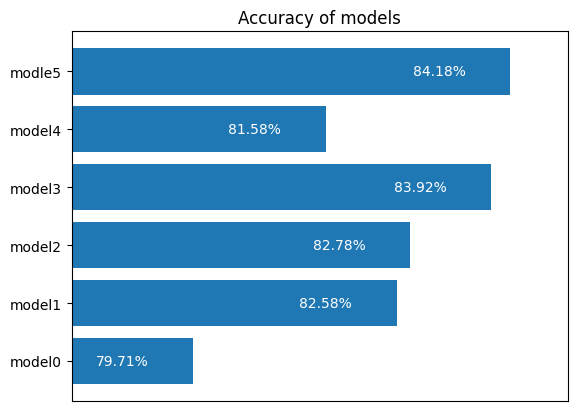

In [118]:
fig, ax = plt.subplots()
bars =  ax.barh(models_names, model_accuracy)

# Add labels to the bars
for bar in bars:
    width = bar.get_width()  # Get the width of the bar (i.e., the value)
    ax.text(width-1, bar.get_y() + bar.get_height() / 2,
            f'{np.round(width, 2)}%', ha='center', va='center', c = 'white')
    
ax.set_xlim(78, 85)
ax.set_title('Accuracy of models')
ax.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)

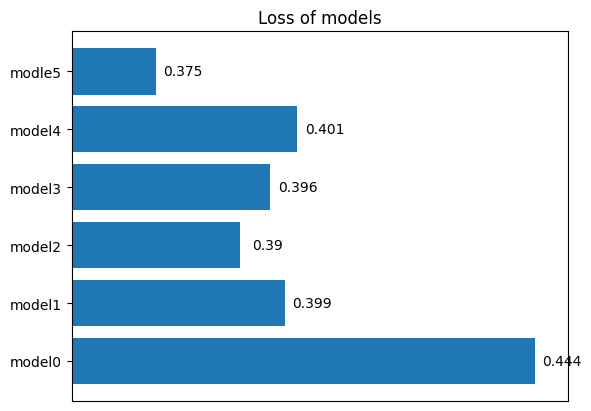

In [119]:
fig, ax = plt.subplots()
bars =  ax.barh(models_names, model_loss)

# Add labels to the bars
for bar in bars:
    width = bar.get_width()  # Get the width of the bar (i.e., the value)
    ax.text(width+0.005, bar.get_y() + bar.get_height() / 2,
            f'{np.round(width, 3)}', ha='center', va='center')

ax.set_xlim(0.36, 0.45)
ax.set_title('Loss of models')
ax.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)